# Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Mounting the google drive

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/drive/MyDrive/isic_images/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/isic_images/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Creating dataset

In [6]:
# Define some parameters for the loader

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
# use seed=123 and resizing the image to 180x180 as per instructions

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# use seed=123 and resizing the image to 180x180 as per instructions

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out all the classes of skin cancer and storing them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data

Creating a code to visualize one instance of all the nine classes present in the dataset.

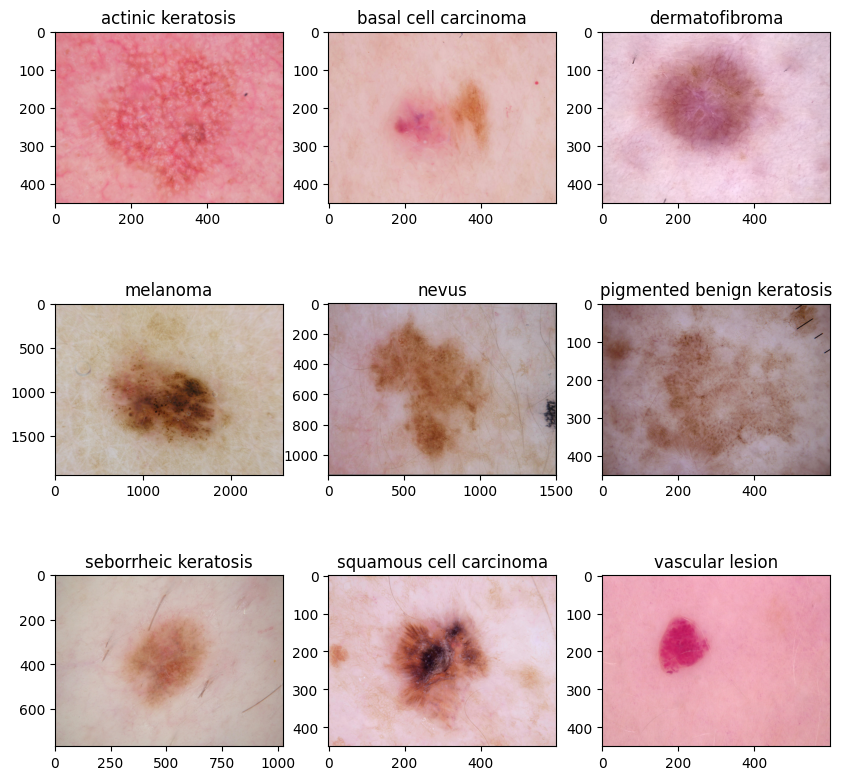

In [10]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The image_batch is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating, Compiling and Training the model

### Creating the model

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

classCount = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(classCount, activation = "softmax"))

### Compiling the model

In [13]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [14]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [15]:
# Training the model for 20 epochs
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 327s 1s/step - loss: 2.0554 - accuracy: 0.1964 - val_loss: 2.0467 - val_accuracy: 0.1700
Epoch 2/20
56/56 [==============================] - 5s 89ms/step - loss: 1.9355 - accuracy: 0.2589 - val_loss: 1.8561 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 5s 89ms/step - loss: 1.8365 - accuracy: 0.3064 - val_loss: 1.7466 - val_accuracy: 0.3602
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.7823 - accuracy: 0.3237 - val_loss: 1.7485 - val_accuracy: 0.3445
Epoch 5/20
56/56 [==============================] - 5s 88ms/step - loss: 1.6675 - accuracy: 0.3923 - val_loss: 1.6950 - val_accuracy: 0.3557
Epoch 6/20
56/56 [==============================] - 5s 89ms/step - loss: 1.5931 - accuracy: 0.4135 - val_loss: 1.6815 - val_accuracy: 0.3848
Epoch 7/20
56/56 [==============================] - 5s 88ms/step - loss: 1.5264 - accuracy: 0.4431 - val_loss: 1.5700 - val_accuracy: 0.4362
Epoch 8/20
56/56 [======

### Visualizing the results

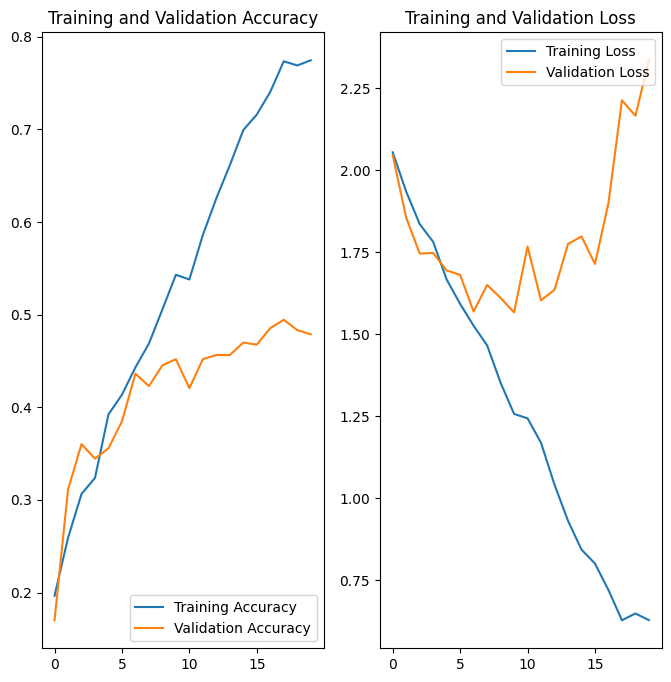

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Findings

- Model is overfitting.
- Model accurcy deviated from 6th or 7th epoch.
- Model loss deviated from 6th or 7th epoch.

In [18]:
# Choosing a strategy for augmentation

augmentedData = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

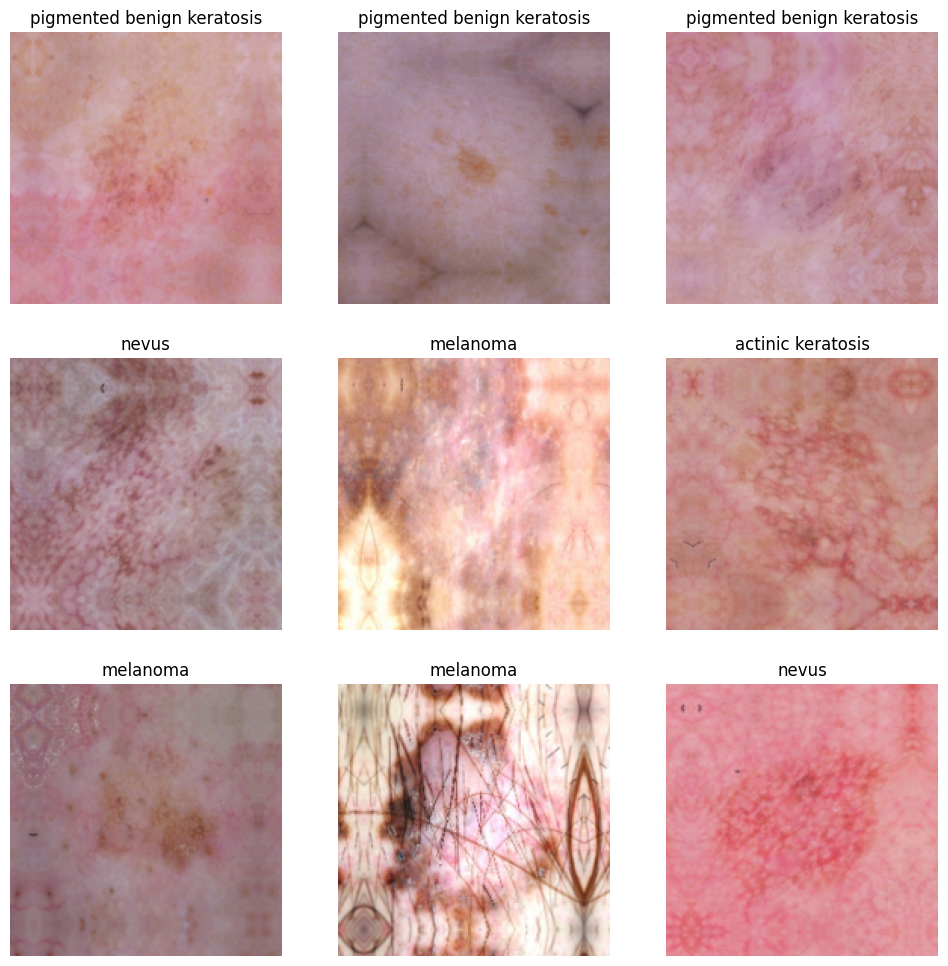

In [19]:
# Visualizing how augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmentedData(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Create the model, compile and train the model on augmented data

### Creating the model

In [20]:
classCount = 9

model = Sequential([ augmentedData,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(classCount, activation = "softmax"))

### Compiling the model

In [21]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Training the model

In [22]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 9s 108ms/step - loss: 2.0624 - accuracy: 0.1931 - val_loss: 2.0022 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 2.0138 - accuracy: 0.2188 - val_loss: 1.9455 - val_accuracy: 0.2327
Epoch 3/20
56/56 [==============================] - 5s 98ms/step - loss: 1.9453 - accuracy: 0.2595 - val_loss: 1.9750 - val_accuracy: 0.2931
Epoch 4/20
56/56 [==============================] - 5s 97ms/step - loss: 1.8787 - accuracy: 0.2924 - val_loss: 1.8091 - val_accuracy: 0.3244
Epoch 5/20
56/56 [==============================] - 6s 98ms/step - loss: 1.7814 - accuracy: 0.3404 - val_loss: 1.8775 - val_accuracy: 0.2864
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 1.7197 - accuracy: 0.3605 - val_loss: 1.6283 - val_accuracy: 0.3758
Epoch 7/20
56/56 [==============================] - 5s 98ms/step - loss: 1.7063 - accuracy: 0.3906 - val_loss: 1.6626 - val_accuracy: 0.4116
Epoch 8/20
56/56 [=====

### Visualizing th results

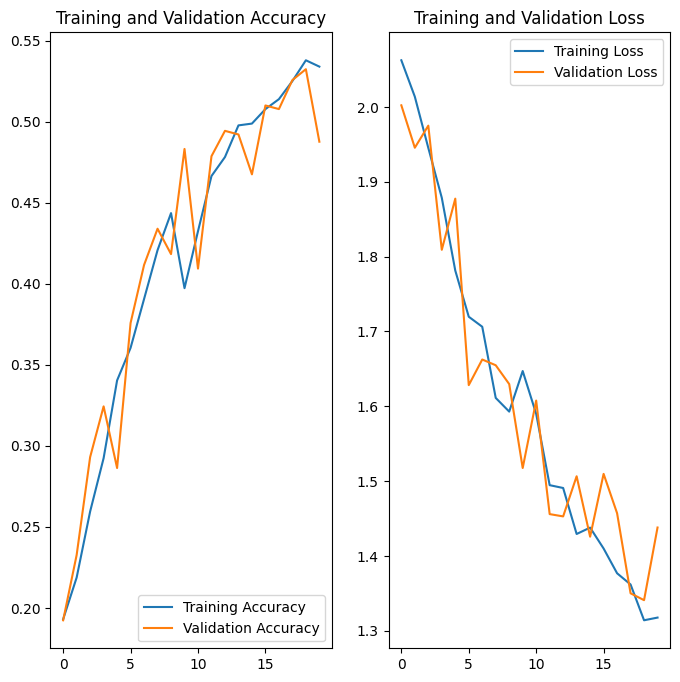

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
- Model has improved from the previous one.
- Model can be imporved further.
- There are few significan deviations in training and validation accuracy.
- There are few significan deviations in training and validation loss.

# Finding and treating the class imbalances.
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/isic_images/Train/actin...,actinic keratosis
1,/content/drive/MyDrive/isic_images/Train/actin...,actinic keratosis
2,/content/drive/MyDrive/isic_images/Train/actin...,actinic keratosis
3,/content/drive/MyDrive/isic_images/Train/actin...,actinic keratosis
4,/content/drive/MyDrive/isic_images/Train/actin...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/isic_images/Train/vascu...,vascular lesion
2235,/content/drive/MyDrive/isic_images/Train/vascu...,vascular lesion
2236,/content/drive/MyDrive/isic_images/Train/vascu...,vascular lesion
2237,/content/drive/MyDrive/isic_images/Train/vascu...,vascular lesion


<BarContainer object of 9 artists>

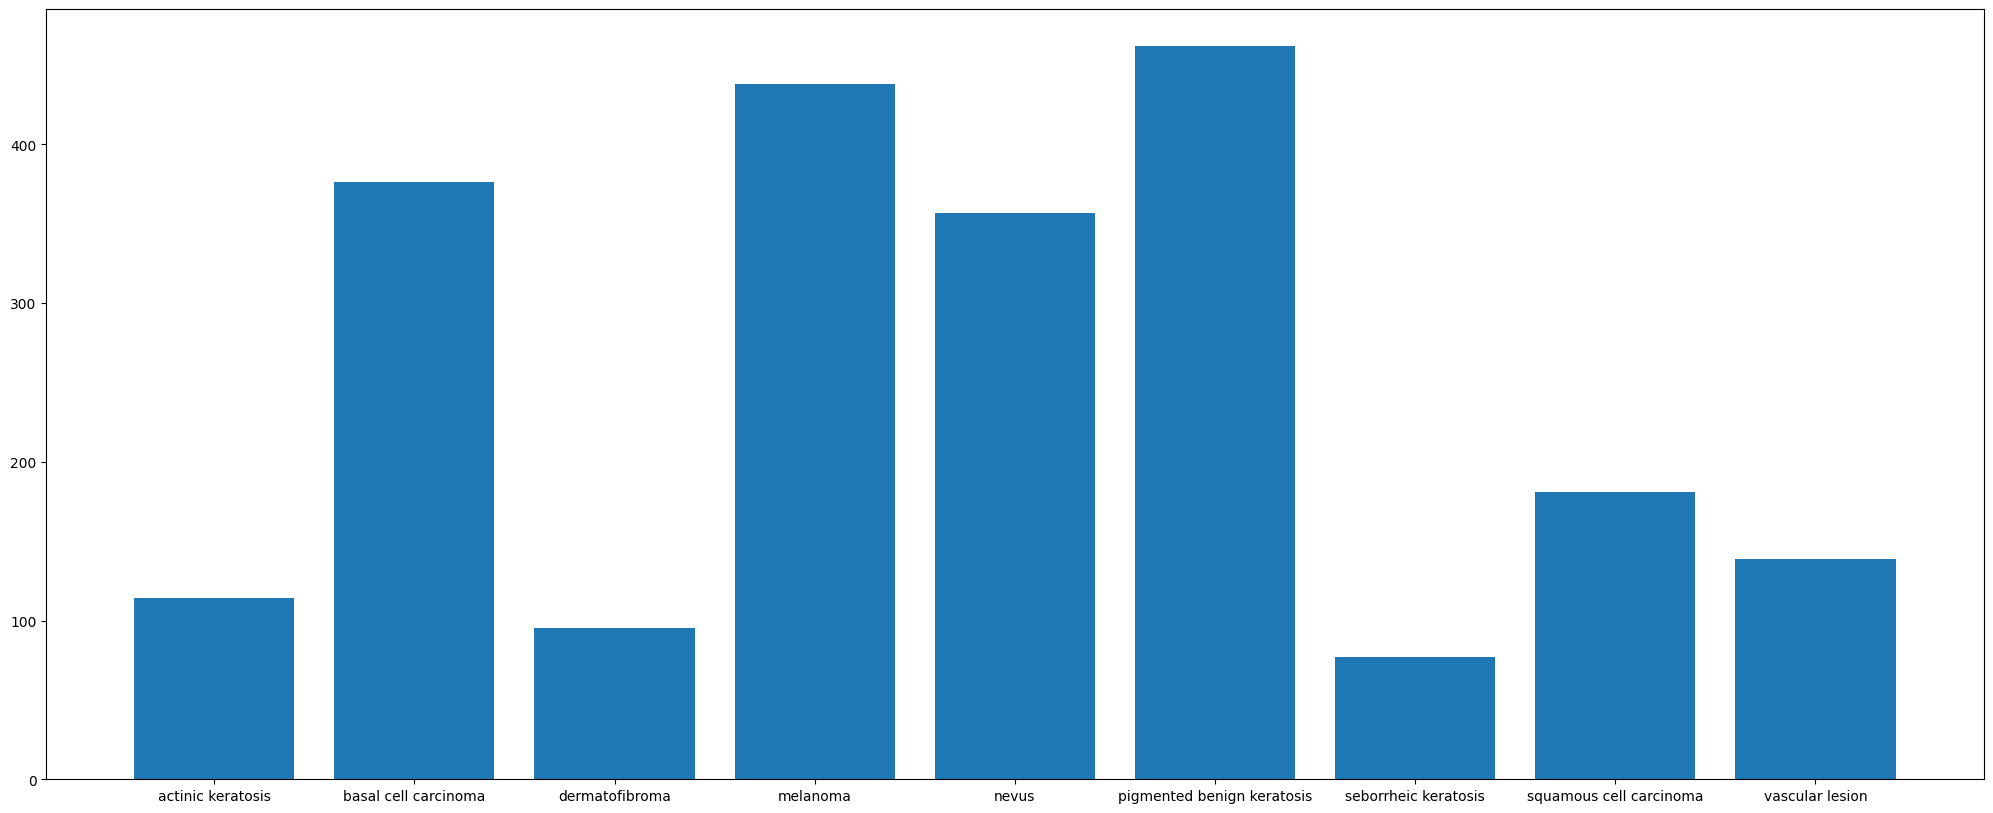

In [28]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

### Findings of class imbalance analysis

- `seborrheic keratosis` has the least number of samples.
- `basal cell carcinoma & nevus`, `actinic keratosis & dermatofibroma`, `melanoma & pigmented benign keratosis`. have proportionate number fo classes.

In [29]:
!pip install Augmentor

In [32]:
path_to_training_dataset="/content/drive/MyDrive/isic_images/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/isic_images/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7885BC487D90>: 100%|██████████| 500/500 [00:17<00:00, 27.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/isic_images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7885CAC4DFC0>: 100%|██████████| 500/500 [00:19<00:00, 26.31 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/isic_images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7885BC3D4790>: 100%|██████████| 500/500 [00:18<00:00, 27.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/isic_images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x78866C203DC0>: 100%|██████████| 500/500 [01:29<00:00,  5.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/isic_images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7885CAEC65C0>: 100%|██████████| 500/500 [01:23<00:00,  5.97 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/isic_images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78866814EEC0>: 100%|██████████| 500/500 [00:17<00:00, 27.90 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/isic_images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7886689AA3E0>: 100%|██████████| 500/500 [00:43<00:00, 11.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/isic_images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7885CABEE1A0>: 100%|██████████| 500/500 [00:18<00:00, 26.34 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/isic_images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7886737D82E0>: 100%|██████████| 500/500 [00:19<00:00, 25.11 Samples/s]


In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/isic_images/Train/melanoma/output/melanoma_original_ISIC_0009908.jpg_3668d07e-e082-440d-9702-903920b01c0d.jpg',
 '/content/drive/MyDrive/isic_images/Train/melanoma/output/melanoma_original_ISIC_0009992.jpg_8c199b60-1faf-498d-9a91-b03353f7d525.jpg',
 '/content/drive/MyDrive/isic_images/Train/melanoma/output/melanoma_original_ISIC_0001118.jpg_97c8f388-b280-409e-b100-7dcb520ccccb.jpg',
 '/content/drive/MyDrive/isic_images/Train/melanoma/output/melanoma_original_ISIC_0000168.jpg_2576b7f6-c687-42aa-b717-ee5dc399f788.jpg',
 '/content/drive/MyDrive/isic_images/Train/melanoma/output/melanoma_original_ISIC_0000302.jpg_967536d9-7521-46bc-a639-6da107c253e3.jpg',
 '/content/drive/MyDrive/isic_images/Train/melanoma/output/melanoma_original_ISIC_0011077.jpg_6337e1d1-4cb9-4344-b74f-c7a599cbb677.jpg',
 '/content/drive/MyDrive/isic_images/Train/melanoma/output/melanoma_original_ISIC_0000551.jpg_86e954f3-8fa0-477c-9a8b-1a05453dc7e0.jpg',
 '/content/drive/MyDrive/isic_images/Trai

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [52]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [55]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-55-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [57]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# Train the model on the data created using Augmentor

In [58]:
batch_size = 32
img_height = 180
img_width = 180

# Creating a training dataset

In [60]:
data_dir_train1 = pathlib.Path("/content/drive/MyDrive/isic_images/Train/")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [61]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating the model

In [63]:
classCount = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(classCount, activation = "softmax"))

# Compiling your model

In [64]:
model.compile(optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

# Training the model

In [65]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 46s 254ms/step - loss: 2.1954 - accuracy: 0.1397 - val_loss: 2.1998 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 41s 234ms/step - loss: 2.2158 - accuracy: 0.1426 - val_loss: 2.1982 - val_accuracy: 0.1425
Epoch 3/30
169/169 [==============================] - 42s 241ms/step - loss: 2.1785 - accuracy: 0.1385 - val_loss: 2.1901 - val_accuracy: 0.1218
Epoch 4/30
169/169 [==============================] - 40s 233ms/step - loss: 2.6170 - accuracy: 0.1411 - val_loss: 2.1944 - val_accuracy: 0.1440
Epoch 5/30
169/169 [==============================] - 41s 237ms/step - loss: 2.1753 - accuracy: 0.1424 - val_loss: 2.1823 - val_accuracy: 0.1448
Epoch 6/30
169/169 [==============================] - 39s 225ms/step - loss: 2.1749 - accuracy: 0.1371 - val_loss: 2.1783 - val_accuracy: 0.1463
Epoch 7/30
169/169 [==============================] - 39s 216ms/step - loss: 2.2038 - accuracy: 0.1424 - val_loss: 2.1823 - val_accuracy: 0.1

# Findings

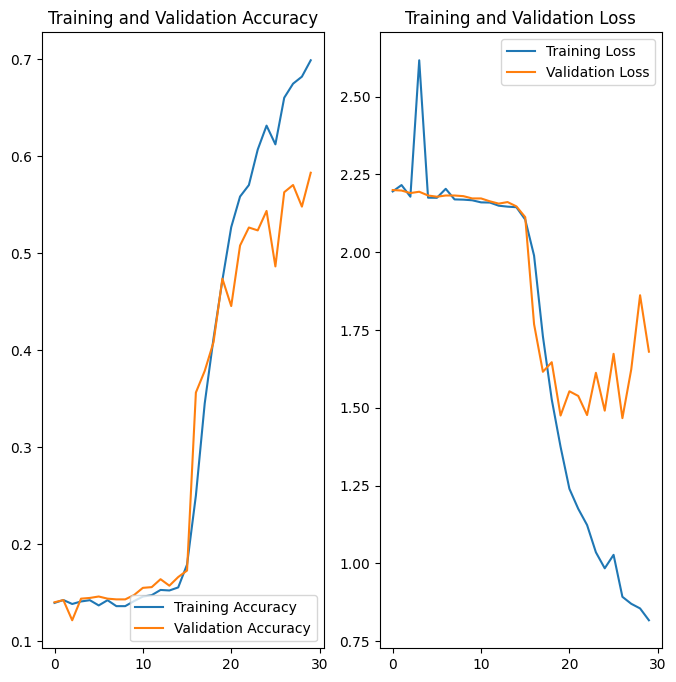

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Findings

- There are still some signs of overfitting.
- Accuracy has increased and is stable.
- Treating class imbalance has affected the accuracy and made it stable at an extent.
- Further the model can be enhanced with more layers, neurons and hyperparameters.
